In [1]:
# for getting JavaScript rendered HTML
from selenium.webdriver import Firefox
# Objects for implicit waits
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
# for explicit waits
import time
# for getting raw HTML without JS rendered
import requests
# for processing HTML
from bs4 import BeautifulSoup
# for linear fit depretiation graphs
import numpy as np
# for saving data
import pandas as pd
# for ploting data
import matplotlib.pyplot as plt
# figures will use 'ggplot' style 
plt.style.use('ggplot')

# 1. Extract graph data

## 1.1 Download JavaScript rendered HTML code

One can use other webdrivers (`Firefox` was used for HTML code analysis).

* `executable_path` is **depretatited** for `selenium` ver. `>=4.0`

In [2]:
# create webdriver, ADD your own path!!!
driver = Firefox(executable_path=r"ADD_YOUR_CODE")
# maximize window
driver.maximize_window()

In [3]:
# load example URL for testing scraping
url = 'https://autoplius.lt/skelbimai/volkswagen-golf-1-4-l-universalas-2017-benzinas-16955821.html'
driver.get(url)

In [4]:
# create wait object
wait = WebDriverWait(driver, 20)
# wait till pop-up appears and click
try:
    e = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[@id='onetrust-accept-btn-handler']")))
except:
    print("pop-up didn't appear within 20 sec")
else:
    e.click()

### Example of add page

![Example_of add page](images/wv_add_example.png "vw_golf_add_example")

## 1.2 Extract data from `svg` graph

Locate figure using `xpath`.
![WV 2017 devaluation graph](images/vw_golf_2017_devaluation.png "vw_golf_devaluation")

In [5]:
# take screen shot of devaluation graph
fname = 'images/vw_golf_2017_devaluation.png'
driver.find_element_by_xpath("//div[@class='row devaluation-row']").screenshot(fname);

By inspecting HTML elements, one can find that graph was Java Scriped rendered and data (year and price) is stored in x-, y- coordinate values, `cx` and `cy` respectively.

![Breakdown HTML code](images/data_located.png "devaluation_data") 

In [6]:
# use beautiful soup to parse html code
soup = BeautifulSoup(driver.page_source, "lxml")
# get chart element
chart = soup.find('div', {'class': 'row devaluation-row'})

In [7]:
"""
data is stored in x and y coordinates. To convert these back to years and euros,
one needs to extract conversion values from x and y axis ticks
"""

# get x and y values from legend object
legend = chart.findAll('text')
# year values based on x coordinates
year_dict = {_['x']:_.text for _ in legend if _['text-anchor'] == 'middle'}
# x- coordinates and coresponding years
year_dict

{'216.5': '2017',
 '377.25': '2018',
 '538': '2019',
 '698.75': '2020',
 '859.5': '2021'}

In [8]:
# get prices from y coordinates
# substact 3.5 from y axis to account for names offset
x_price = [float(_['y'])-3.5 for _ in legend if _['text-anchor'] == 'end']
y_price = [int(_.text[:-2]) for _ in legend if _['text-anchor'] == 'end']
print(f'x- coordinates: {x_price}')
print(f'y- values:      {y_price}')

x- coordinates: [272.5, 223.7, 174.9, 126.1, 77.3, 28.5]
y- values:      [0, 5000, 10000, 15000, 20000, 25000]


In [9]:
# apply linear fit to extract intermediate price values
# y = k*x+c, where k slope, c- constant
k, c = np.polyfit(x_price, y_price, 1)
print(f'y = {k:.2f}x + {c:.2f}')

y = -102.46x + 27920.08


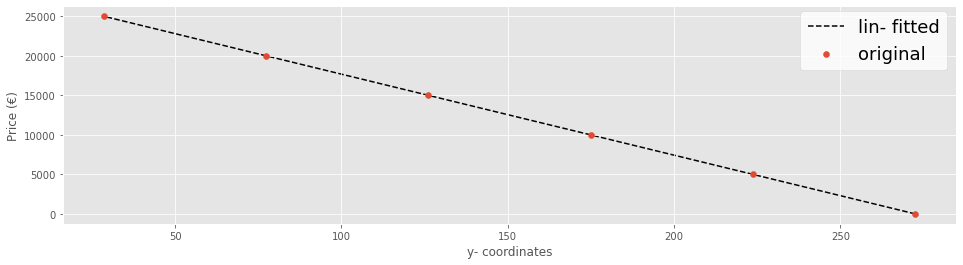

In [10]:
# visualize equation
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(x_price, y_price, label='original')
_x_fit = np.linspace(x_price[0], x_price[-1], 50)
ax.plot(_x_fit, k*_x_fit+c, 'k--', label='lin- fitted', zorder=-1)

# add x- and y- axis labels
ax.set_xlabel('y- coordinates')
ax.set_ylabel('Price (€)')

# add legend with white background
legend = ax.legend(frameon = 1, fontsize=18, bbox_to_anchor=(1., 1.02))
frame = legend.get_frame()
frame.set_facecolor('w')

In [11]:
# now we can extract any price by knowing data point coordinates
# get positions of all data points
data_points = chart.findAll('circle')
# based on object fill color seprate points into low, medium and high price lists
# use k and c fit values to extract prices

# get year column from low prices
data = [[year_dict[_['cx']] for _ in data_points if _['fill'] == '#76ddfa']]
# get prices using fill color, low prices
data.append([int(k*float(_['cy'])+c) for _ in data_points if _['fill'] == '#76ddfa'])
# medium prices
data.append([int(k*float(_['cy'])+c) for _ in data_points if _['fill'] == '#428dc2'])
# high prices
data.append([int(k*float(_['cy'])+c) for _ in data_points if _['fill'] == '#60ade1'])
# create DataFrame and transpose it
df = pd.DataFrame(data, index=['Year', 'Low', 'Medium', 'High']).T
df

,Year,Low,Medium,High
0,2017,15300,17200,22100
1,2018,12700,16800,20100
2,2019,10300,14200,18200
3,2020,7900,11000,14600
4,2021,8200,11200,14500


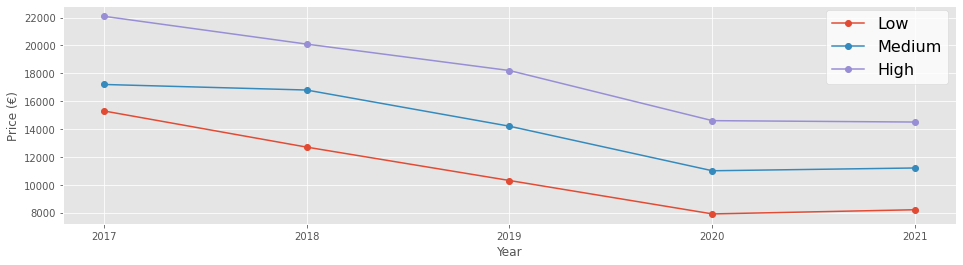

In [12]:
# visualize
fig, ax = plt.subplots(figsize=(16, 4))
for col in ['Low', 'Medium', 'High']:
    ax.plot(df.Year, df[col], 'o-', label=col)
    
ax.set_xlabel('Year')
ax.set_ylabel('Price (€)')

# add legend with white background
legend = ax.legend(frameon = 1, fontsize=16, bbox_to_anchor=(1., 1.02))
frame = legend.get_frame()
frame.set_facecolor('w')

## 1.3 Create function for extrating data from `.svg` graph

In [13]:
def get_deval_data(soup):
    """
    Returns pandas DataFrame with 4 columns:
    - year (str),
    - low (int), low price,
    - medium (int), medium price,
    - high (int), high price.
    Input:
        soup: bs4 element, html
    Output:
        pandas DataFrame
    """
    # get chart element
    chart = soup.find('div', {'class': 'row devaluation-row'})
    # get x and y values from legend object
    legend = chart.findAll('text')
    # year values based on x coordinates
    year_dict = {_['x']:_.text for _ in legend if _['text-anchor'] == 'middle'}
    # get prices from y coordinates
    # substact 3.5 from y axis to account for names offset
    _x = [float(_['y'])-3.5 for _ in legend if _['text-anchor'] == 'end']
    _y = [int(_.text[:-2]) for _ in legend if _['text-anchor'] == 'end']
    # apply linear fit to extract intermediate price values
    # y = k*x+c, where k slope, c- constant
    k, c = np.polyfit(_x, _y, 1)
    # get positions of all data points
    data_points = chart.findAll('circle')
    # get year column from low prices
    data = [[year_dict[_['cx']] for _ in data_points if _['fill'] == '#76ddfa']]
    # get prices using fill color, low prices
    data.append([int(k*float(_['cy'])+c) for _ in data_points if _['fill'] == '#76ddfa'])
    # medium prices
    data.append([int(k*float(_['cy'])+c) for _ in data_points if _['fill'] == '#428dc2'])
    # high prices
    data.append([int(k*float(_['cy'])+c) for _ in data_points if _['fill'] == '#60ade1'])
    # create DataFrame and transpose it
    return pd.DataFrame(data, index=['Year', 'Low', 'Medium', 'High']).T    

In [14]:
# test function on another random car add
url = 'https://autoplius.lt/skelbimai/mercedes-benz-e320-3-2-l-universalas-2004-dyzelinas-17690273.html'
# create wait object
wait = WebDriverWait(driver, 20)
# go to page
driver.get(url)
# scroll down 
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
# wait till chart object becomes visible
try:
    wait.until(EC.visibility_of_element_located((By.ID, "devaluation-chart")))  
except TimeoutException:
    print("Chart object is not available or didn't load within 20 sec.")
    
# create beautiful soup element to parse html code
soup = BeautifulSoup(driver.page_source, "lxml")

# double check if chart is available
if soup.find('div', {'class': 'row devaluation-row'}):
    df = get_deval_data(soup)
    # take screen shot of depresiation graph
    fname = 'devaluation_random.png'
    driver.find_element_by_xpath("//div[@class='row devaluation-row']").screenshot(fname)
else:
    df = pd.DataFrame()  
df

,Year,Low,Medium,High
0,2011,8700,10800,12500
1,2012,6400,8100,10000
2,2013,5300,7100,8800
3,2014,4700,6000,7500
4,2015,4000,5300,6800
5,2016,3900,5000,6300
6,2017,3400,4600,5900
7,2018,2800,4000,5200
8,2019,2300,3400,4500
9,2020,2100,3000,4000


In [15]:
# take screen shot of devaluation graph
fname = 'images/MB_E320_2004_devaluation.png'
driver.find_element_by_xpath("//div[@class='row devaluation-row']").screenshot(fname);

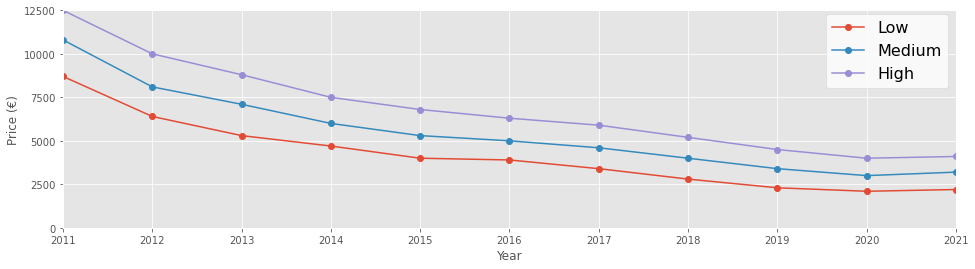

In [16]:
# visualize
fig, ax = plt.subplots(figsize=(16, 4))
for col in ['Low', 'Medium', 'High']:
    ax.plot(df.Year.astype(int), df[col], 'o-', label=col)
    
ax.set_xlabel('Year')
ax.set_ylabel('Price (€)')

# make same y-axis ranges as in the example
ax.set_yticks(np.arange(0, 13000, 2500))
ax.set_ylim(0, 12500)
ax.set_xticks(np.arange(2011, 2022, 1))
ax.set_xlim(2011, 2021)

# add legend with white background
legend = ax.legend(frameon = 1, fontsize=16, bbox_to_anchor=(1., 1.02))
frame = legend.get_frame()
frame.set_facecolor('w')

Got same data as expected.
![](images/MB_E320_2004_devaluation.png "Mercedes-Benz E320 devaluation data") 


In [17]:
def read_chart(url, fname='devaluation_random.png'):
    """
    Save devaluation graph to .png file and returns DataFrame with it's data if
    such graph is available in car add referenced by url variable.    
    Input:
        url, str, link to autoplius car add,
        fname, str, file name for saving image
    Output:
        pandas DataFrame or None if graph was not found
    """
    global driver, wait
    # go to page
    driver.get(url)
    # scroll down 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # wait till chart object becomes visible
    try:
        wait.until(EC.visibility_of_element_located((By.ID, "devaluation-chart")))

    except TimeoutException:
        print("Chart object is not available or didn't load within 20 sec.")
        # exit function with None
        return None
        
    # create beautiful soup element to parse html code
    soup = BeautifulSoup(driver.page_source, "lxml")
        
    # double check if chart is available
    if soup.find('div', {'class': 'row devaluation-row'}):
        # create DataFrame
        df = get_deval_data(soup)
        # take screen shot of depresiation graph
        driver.find_element_by_xpath("//div[@class='row devaluation-row']").screenshot(fname)
    else:
        # if chart is not preset return None value as DataFrame
        df = None
        
    return df

In [18]:
# random add
url = 'https://autoplius.lt/skelbimai/mazda-6-2-5-l-sedanas-2018-benzinas-17360953.html'
# test function
df = read_chart(url)
df

,Year,Low,Medium,High
0,2018,30499,30499,30499
1,2019,19199,20199,20899
2,2020,15599,16899,18199
3,2021,15399,17099,18799


# 2. Get most popular car model urls

## 2.1 Count how many adds per car manufacturer

In [19]:
# use mobile website version for better HTML code readability
url = 'https://m.autoplius.lt/paieska/reiksmes-parinkimas/naudoti-automobiliai?field_name=make_id&parent_value_id=104&title_page=1&qt=&qt_autocomplete=&category_id=2'
# go to page
driver.get(url)

In [20]:
# create beautiful soup element to parse html code
soup = BeautifulSoup(driver.page_source, "lxml")
# get search results
rows = soup.find('section', {'class': 'panel'}).findAll('a', {'class': 'search-dropdown'})
# create empty list for storing data
data = list()
# iterate over rows
for row in rows:
    add_count = int(row.span.text)
    # record car manufacturers with atleast 50 available car adds
    if add_count >= 50:
        data.append([row['title'], add_count])
        
# create DataFrame with add count per manufacturer    
df_man = pd.DataFrame(data, columns=['Manufacturer', 'Add_count'])
df_man.head()

,Manufacturer,Add_count
0,Alfa Romeo,107
1,Audi,2905
2,BMW,4133
3,Chevrolet,251
4,Chrysler,251


In [21]:
# same, but with list comprehension
# get search results
rows = soup.find('section', {'class': 'panel'}).findAll('a', {'class': 'search-dropdown'})
data = [[row['title'], int(row.span.text)] for row in rows if int(row.span.text) >= 50]
# create DataFrame with add count per manufacturer    
df_man = pd.DataFrame(data, columns=['Manufacturer', 'Add_count'])
df_man.head()

,Manufacturer,Add_count
0,Alfa Romeo,107
1,Audi,2905
2,BMW,4133
3,Chevrolet,251
4,Chrysler,251


## 2.2 Count how many adds per car manufacturer (second approach)

In [22]:
url = 'https://autoplius.lt/'
# go to page
driver.get(url)
# click car manufacturer element
driver.find_element_by_xpath("//div[@class='display-input js-placeholder']").click()

In [23]:
# get page sourse
soup = BeautifulSoup(driver.page_source, "lxml")

rows = soup.findAll('div', {'class': 'dropdown-option js-option'})
# get manufacturer names with atleast 50 adds
data = list()
for row in rows:
    # get contents
    c = row.findAll('div')
    if len(c)==2 and int(c[1].text) >= 50:
        data.append([c[0].text, c[1].text])
        
# create DataFrame with add count per manufacturer    
df_man = pd.DataFrame(data, columns=['Manufacturer', 'Add_count'])
df_man.head()

,Manufacturer,Add_count
0,Alfa Romeo,107
1,Audi,2905
2,BMW,4134
3,Chevrolet,252
4,Chrysler,251


# 3. Extract car info

Iterate over all car adds with prices in range [2000-60000 eur] and which made not older than 10 year (i.e. made in 2011 and later).

## 3.1 Test search engine on single page

In [24]:
year_from = 2011
# in euros
price_min = 2000
price_max = 60000

# generate URL page
url = 'https://autoplius.lt/skelbimai/naudoti-automobiliai?'
url += f'make_date_from={year_from}&sell_price_from={price_min}&sell_price_to={price_max}&page_nr=1'
# double check if it works
print(url)

https://autoplius.lt/skelbimai/naudoti-automobiliai?make_date_from=2011&sell_price_from=2000&sell_price_to=60000&page_nr=1


In [25]:
# for faster loading (there is no need for JavaScript rendering)
# use basic request library with bs4
# get raw HTML
resp = requests.get(url)
# use beautiful soup to parse html code
soup = BeautifulSoup(resp.text, "lxml")

# get all adds
adds = soup.find('div', {'class': 'auto-lists lt'}).findAll('a', {'target': '_blank'})

# temporaty list to store recorded data
_data = list()

for add in adds:
    # exclude month, get only first 4 symbols
    year_made = add.find('span', {'title': "Pagaminimo data"}).text.strip()[:4]
    add_url = add['href']
    # car name
    car_name = add.find('div', {'class': "announcement-title"}).text.strip().split(',')[0]
    _data.append([car_name, year_made, add_url])
    
# create new DataFrame to store which cars were searched
df_adds = pd.DataFrame(_data, columns=['Model', 'Made_year', 'ADD_URL'])
df_adds.head()

,Model,Made_year,ADD_URL
0,BMW 730,2016,https://autoplius.lt/skelbimai/bmw-730-3-0-l-s...
1,Nissan Qashqai,2014,https://autoplius.lt/skelbimai/nissan-qashqai-...
2,Volkswagen Tiguan,2018,https://autoplius.lt/skelbimai/volkswagen-tigu...
3,BMW X5,2015,https://autoplius.lt/skelbimai/bmw-x5-3-0-l-vi...
4,Land Rover Range Rover Sport,2014,https://autoplius.lt/skelbimai/land-rover-rang...


## 3.2 Read adds urls for first 10 pages

In [26]:
# get adds for first 10 pages
year_from = 2010
# in euros
price_min = 2000
price_max = 60000

# generate URL page
url = 'https://autoplius.lt/skelbimai/naudoti-automobiliai?'
url += f'make_date_from={year_from}&sell_price_from={price_min}&sell_price_to={price_max}&page_nr='

# temp list to store adds info
_data = list()

for page in range(1, 11):
    # temporary url
    _url = url + str(page)
    # get raw HTML
    resp = requests.get(_url)
    # use beautiful soup to parse html code
    soup = BeautifulSoup(resp.text, "lxml")
    # get all adds
    adds = soup.find('div', {'class': 'auto-lists lt'}).findAll('a', {'target': '_blank'})

    for add in adds:
        # exclude month, get only first 4 symbols
        year_made = add.find('span', {'title': "Pagaminimo data"}).text.strip()[:4]
        add_url = add['href']
        # car name
        car_name = add.find('div', {'class': "announcement-title"}).text.strip().split(',')[0]
        _data.append([car_name, year_made, add_url])
        
    # add explicit wait random wait from 200 ms to 2 sec
    time.sleep(np.random.randint(1, 20)/20)
    
# create new DataFrame with add's urls
df_adds = pd.DataFrame(_data, columns=['Car', 'Year_made', 'Add_url'])
df_adds.head()

,Car,Year_made,Add_url
0,BMW 730,2016,https://autoplius.lt/skelbimai/bmw-730-3-0-l-s...
1,Nissan Qashqai,2014,https://autoplius.lt/skelbimai/nissan-qashqai-...
2,Audi A5 SPORTBACK,2010,https://autoplius.lt/skelbimai/audi-a5-sportba...
3,BMW 530 Gran Turismo,2010,https://autoplius.lt/skelbimai/bmw-530-gran-tu...
4,Volkswagen Tiguan,2018,https://autoplius.lt/skelbimai/volkswagen-tigu...


In [27]:
# drop duplicates, keep first add which appears in DataFrame
print(f'Before droping {len(df_adds)} found')
df_adds = df_adds.drop_duplicates(subset=['Car', 'Year_made'], keep='first')
print(f'After droping {len(df_adds)} found')

Before droping 200 found
After droping 175 found


### One can use `while` loop to extract all available add pages

But such approach requires longer waits so that bot doesn't get detected (too frequent http requests).

In [28]:
# get adds for only one year
year_min = 2011
year_max = 2011
# in euros
price_min = 2000
price_max = 60000

# generate URL page
url = 'https://autoplius.lt/skelbimai/naudoti-automobiliai?'
url += f'make_date_from={year_min}&make_date_to={year_max}'
url += f'&sell_price_from={price_min}&sell_price_to={price_max}&sell_price_to=60000&page_nr='
print(url)

https://autoplius.lt/skelbimai/naudoti-automobiliai?make_date_from=2011&make_date_to=2011&sell_price_from=2000&sell_price_to=60000&sell_price_to=60000&page_nr=


In [29]:
# temp list to store adds info
_data = list()
# for creating new url and sending progress messages
page = 1

# temporary url
_url = url + str(page)
# get raw HTML
resp = requests.get(_url)
# use beautiful soup to parse html code
soup = BeautifulSoup(resp.text, "lxml")

while soup.find('a', {'class': 'next'}):
    # temporary url
    _url = url + str(page)
    # get raw HTML
    resp = requests.get(_url)
    # use beautiful soup to parse html code
    soup = BeautifulSoup(resp.text, "lxml")
    # get all adds
    adds = soup.find('div', {'class': 'auto-lists lt'}).findAll('a', {'target': '_blank'})

    for add in adds:
        # exclude month, get only first 4 symbols
        year_made = add.find('span', {'title': "Pagaminimo data"}).text.strip()[:4]
        add_url = add['href']
        # car name
        car_name = add.find('div', {'class': "announcement-title"}).text.strip().split(',')[0]
        _data.append([car_name, year_made, add_url])
        
    # add explicit wait random wait from 100 ms to 2 sec
    time.sleep(np.random.randint(1, 20)/20)
    
    # send progress every 10 pages
    if page%10 == 0:
        print(f'{page} pages loaded.')
    
    page += 1    
    
print(f'{page} pages loaded.')

# create new DataFrame with add's urls
df_adds = pd.DataFrame(_data, columns=['Car', 'Year_made', 'Add_url'])
print(f'Before droping unique values {len(df_adds)} found')

# drop duplicates, keep first add which appears in DataFrame
df_adds = df_adds.drop_duplicates(subset=['Car', 'Year_made'], keep='first').reset_index(drop=True)
print(f'After droping unique values {len(df_adds)} found')

10 pages loaded.
20 pages loaded.
30 pages loaded.
40 pages loaded.
50 pages loaded.
60 pages loaded.
70 pages loaded.
80 pages loaded.
90 pages loaded.
98 pages loaded.
Before droping unique values 1923 found
After droping unique values 318 found


## 3.3 Scrape all devaluation graphs

This is just test. This code should be implemented into `.py` file script and run in `head-less` mode or copied to cloud, e.g. Google colab.

In [30]:
# create empty DataFrame
df_dep = pd.DataFrame()

# iterate over first 20 car adds
for idx in df_adds.index[:20]:
    # temporary URL
    _url = df_adds.loc[idx, 'Add_url']
    # generate file name for saving depretiation graphs
    # add ~ as separator for seperating file names
    _fname = df_adds.loc[idx, 'Car'].replace(' ', '_') + '~' + df_adds.loc[idx, 'Year_made'] + '.png'
    # read chart, save to temporary DataFrame
    _df = read_chart(_url, _fname)
    
    if _df is not None:
        _df['Car'] = df_adds.loc[idx, 'Car']
        _df['Year_made'] = df_adds.loc[idx, 'Year_made']
        df_dep = pd.concat([df_dep, _df])
    else:
        # generate error message if _df == None
        msg = f"Dep. charts not found for {df_adds.loc[idx, 'Car']} made in {df_adds.loc[idx, 'Year_made']}."
        print(msg)
        
    if (idx+1)%10 == 0:
        # temporary message about progress
        print(f'{idx+1}/{len(df_adds)} completed.')

10/318 completed.
20/318 completed.


In [31]:
df_dep.head()

,Year,Low,Medium,High,Car,Year_made
0,2011,12700,18600,20200,Volkswagen Tiguan,2011
1,2012,17900,19900,21400,Volkswagen Tiguan,2011
2,2013,10000,13300,16300,Volkswagen Tiguan,2011
3,2014,10000,12400,15500,Volkswagen Tiguan,2011
4,2015,10300,13200,15900,Volkswagen Tiguan,2011


In [32]:
# save data to .csv
df_dep.to_csv('2011_cars_test.csv')

In [33]:
# turn off webdriver
driver.quit()